# AlphaFold Assessment of Interactions

*State of the Interactomes: an evaluation of molecular networks for generating biological insights.* Wright, SN et al. [https://doi.org/10.1101/2024.04.26.587073]  
This notebook contains code and results related to:
* Figure 5E-G
* Appendix Figure S3A-E
* EV Figure 5

**Note: due to the size of network data sets utilized in this study, this notebook draws on summarized results rather than re-evaluating all networks directly.**

For information on running AlphaFold, please see Example Analysis below and `Data/ExampleUsage/AlphaFold.README.md`

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neteval.network_statistics import NetworkStats, load_network_names
from neteval.alphafold_results import *
from tqdm import tqdm
import os
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import warnings
import networkx as nx
import pickle
from collections import defaultdict
import random as rn
import glob
from scipy.stats import skewtest, chi2_contingency

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25
blue='#73c7e7'
green='#44cf6c'
orange='#ffa500'

In [3]:
gitdir = os.path.dirname(os.getcwd())
figdir = os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Figures/')
evaldir = os.path.join(gitdir, 'Data/example_outputs/')
datadir = os.path.join(gitdir, 'Data/')
network_names = load_network_names(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/network_names_final.txt'))
example_names = load_network_names(os.path.join(gitdir, 'Data/example_network_names.txt'))
network_classes = load_network_names(os.path.join(gitdir, "StateOfTheInteractomes_Notebooks/Data/network_classifications.txt"))

In [4]:
dataset_ev4 = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/DatasetEV4.txt'), sep='\t')
dataset_ev4 = dataset_ev4.assign(Pair_str = dataset_ev4['NCBI Gene ID A'].astype(int).astype(str) + '-' + dataset_ev4['NCBI Gene ID B'].astype(int).astype(str))


In [5]:
rn_df = dataset_ev4[dataset_ev4['Analysis Set']=='Random background pairs']
rn_df_top = rn_df.sort_values('Model Confidence', ascending=False).drop_duplicates(subset=['Pair_str', 'Network/Network Coverage'], keep='first')


## Example Analysis

This example analysis utilizes three small networks: DIP, PID2, and Wan

### Download Protein Sequence data from Uniprot

Uncomment to download the data (~15mins)

In [6]:
# from neteval.node_annotation import get_uniprot_annotation_data

# uni_df = get_uniprot_annotation_data(fields=['id', 'sequence', 'xref_geneid'], outdir=os.path.join(gitdir, 'Data/'), 
#                                     index_on=2, page_size=500, max_retries=5, taxid=9606, verbose=False)

### Selection of interactions to predict
1. Interactions with a range of network coverages
2. Random sample of interactions from each interactome
3. Top previously unreported interactions predicted by each interactome

In [7]:
# get the UniProt reference data - only possible to predict pairs with protein structures
uni_df = pd.read_csv(os.path.join(gitdir, 'Data/uniprot_data_id_sequence_xref_geneid_2024-02-05.tsv'), sep='\t', index_col=0)

In [8]:
with open(os.path.join(evaldir, "edge_counts.pkl"), 'rb') as f:
    edge_counts = pickle.load(f)
with open(os.path.join(evaldir, "node_mapping.pkl"), 'rb') as f:
    node_mapping = pickle.load(f)
    
rev_node_mapping = {v: k for k, v in node_mapping.items()}
mapped_edge_counts = {(rev_node_mapping[k[0]], rev_node_mapping[k[1]]): v for k, v in edge_counts.items()}
reverse_edge_counts = defaultdict(list)
for k in tqdm(edge_counts):
    edge = (rev_node_mapping[k[0]], rev_node_mapping[k[1]])
    if (edge[0] in uni_df.index) and( edge[1] in uni_df.index):
        reverse_edge_counts[edge_counts[k]].append(edge)

100%|██████████| 57646/57646 [00:00<00:00, 325469.15it/s]


1. Network Coverage Pairs

Randomly sample 50 examples of interactions with each value of network coverage, where network coverage is defined as the number of interactomes that an interaction appears in. 

In [10]:
pairs_to_run = defaultdict(set)
rn_df = rn_df.dropna()
for i in range(0, 4):
    if i == 0:
        # get 50 interactions (from the random background) that are not present in any example interactomes
        rn_df['Edge_count'] = rn_df.apply(lambda x: mapped_edge_counts[(x['NCBI Gene ID A'], x['NCBI Gene ID B'])] if (x['NCBI Gene ID A'], x['NCBI Gene ID B']) in mapped_edge_counts else 0, axis=1)
        coverage_0_pairs = rn_df.loc[rn_df['Edge_count'] == i, ('NCBI Gene ID A', 'NCBI Gene ID B')]
        coverage_0_pairs = [tuple(x) for x in coverage_0_pairs.to_numpy()]
        while len(pairs_to_run[i]) < 50:
            test_pairs = rn.sample(coverage_0_pairs, 50-len(pairs_to_run[i]))
            for pair in test_pairs:
                # check that both proteins have a sequence
                if (pair[0] in uni_df.index.values) & (pair[1] in uni_df.index.values):
                    pairs_to_run[i].add(pair)
    else:
        # get 50 interactions with varying network coverage
        if len(reverse_edge_counts[i]) < 50:
            for pair in reverse_edge_counts[i]:
                if (pair[0] in uni_df.index.values) & (pair[1] in uni_df.index.values):
                    pairs_to_run[i].add(pair)
        else:
            while len(pairs_to_run[i]) < 50:
                test_pairs = rn.sample(reverse_edge_counts[i], 50-len(pairs_to_run[i]))
                for pair in test_pairs:
                    if (pair[0] in uni_df.index.values) & (pair[1] in uni_df.index.values):
                        pairs_to_run[i].add(pair)

In [11]:
for k in pairs_to_run:
    with open(os.path.join(evaldir, f'net_coverage_pairs_to_run_{k}.csv'), 'w') as f:
        for pair in pairs_to_run[k]:
            f.write(f'{pair[0]},{pair[1]}\n')

2. Network samples

Randomly sample 50 interactions from each network

In [12]:
stats = NetworkStats(os.path.join(datadir, 'example_prefix_file.txt'), evaldir)

In [13]:
net_edges_to_run = defaultdict(list)
for pref in stats.prefixes:
    edges = pd.read_csv(stats.edge_files[pref], sep='\t')
    edges = edges.loc[edges['Entrez_A'].isin(uni_df.index) & edges['Entrez_B'].isin(uni_df.index), ('Entrez_A', 'Entrez_B')].to_numpy()
    samp_idx = rn.sample(range(len(edges)), 50)
    samp_edges = edges[samp_idx]
    net_edges_to_run[pref] = samp_edges
    

In [14]:
for net in net_edges_to_run:
    with open(os.path.join(evaldir, f'net_pairs_to_run_{net}.csv'), 'w') as f:
        for pair in net_edges_to_run[net]:
            f.write(f'{pair[0]},{pair[1]}\n')

3. Previously unreported interactions

These are sourced directly from the `...unverified_top50_edges.txt` files generated during evaluation of network coverage (see `ExampleUsage/InteractionPrediction.README.md`. When this analysis is supplied with the sequence information from UniProt it selects from only interactions with both protein sequences available. 

### Extracting AF results

Example for processing the results for the pair BARD1 (ID:580) - BRCA1 (ID:672)

In [15]:
extract_scores((580, 672), os.path.join(gitdir, 'Data/example_outputs/AlphaFold/'))

{'ptm': [0.28, 0.27, 0.28, 0.27, 0.27], 'iptm': [0.51, 0.5, 0.5, 0.49, 0.48]}

## Analyze full results

In [16]:
af_df = dataset_ev4[dataset_ev4['Analysis Set']!='Random background pairs']


### Figure 5E - Network Coverage vs AF ipTM

In [62]:
# Extract the subset of results relevant to the coverage analysis

coverage_df = af_df.copy().loc[af_df['Analysis Set']=='Network Coverage', :]
coverage_df_top = coverage_df.sort_values('Model Confidence', ascending=False).drop_duplicates(subset=['Pair_str'], keep='first')
coverage_df_top['Network/Network Coverage'] = coverage_df_top['Network/Network Coverage'].astype(int)

In [18]:
# Bin the coverage values for better visualization
coverage_df_top['Edge_Bin'] = coverage_df_top['Network/Network Coverage'].apply(lambda x: (x+3)//4)

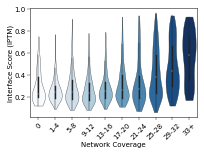

In [19]:
_ = plt.figure(figsize=(3, 2))
ax = plt.gca()
sns.violinplot(coverage_df_top, x='Edge_Bin', y='ipTM', ax=ax, cut=0, hue='Edge_Bin', palette='Blues', legend=False)
_ = plt.xticks([i for i in range(10)], labels=[0, '1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28', '29-32', '33+'], rotation=45)
plt.ylabel('Interface Score (IPTM)')
plt.xlabel('Network Coverage')

plt.savefig(figdir + 'Fig5E_ipTM_vs_coverage.jpg', bbox_inches='tight', dpi=300)

## Figure 5F - ipTM of sample network interactions

In [20]:
# Load the AF results for random samples of 50 interactions per network.
network_df = af_df.copy().loc[af_df['Analysis Set']=='Network Specific', :]
network_df_top = network_df.sort_values('Model Confidence', ascending=False).drop_duplicates(subset=['Pair_str', 'Network/Network Coverage'], keep='first')


Test the shape of the distributions before statistical testing

Text(0, 0.5, 'Network pairs')

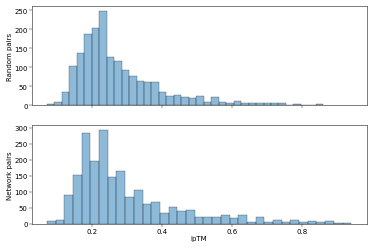

In [21]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, sharex=True)
ax=plt.gca()
sns.histplot(rn_df.ipTM, alpha=0.5, ax=ax1)
sns.histplot(network_df_top[network_df_top['Analysis Set']=='Network Specific'].ipTM, alpha=0.5, ax=ax2)
ax1.set_ylabel('Random pairs')
ax2.set_ylabel('Network pairs')

In [22]:
print('Random pairs skew:')
skewtest(rn_df.ipTM)

Random pairs skew:


SkewtestResult(statistic=20.05597466484295, pvalue=1.790015265459262e-89)

In [23]:
print('Network pairs skew:')
skewtest(network_df_top[network_df_top['Analysis Set']=='Network Specific'].ipTM)

Network pairs skew:


SkewtestResult(statistic=21.96857694917922, pvalue=5.754329307241617e-107)

Perform a Mann Whitney U test

In [24]:
# Perform Mann Whitney U for ipTM scores. 
mu_results = {}
for net in network_df_top['Network/Network Coverage'].unique():
    mu_rn = mannwhitneyu(network_df_top[network_df_top['Network/Network Coverage'] == net].ipTM, rn_df.ipTM).pvalue
    mu_results[net] = {'rn': mu_rn}
mu_df = pd.DataFrame.from_dict(mu_results, orient='index')
mu_df['fdr_rn'] = fdrcorrection(mu_df['rn'])[1]

In [25]:
# Get the medians for each network, and background
random_median = rn_df.ipTM.median()
net_medians = network_df_top.groupby('Network/Network Coverage').ipTM.median()

In [26]:
# Subset the data to networks with significantly higher than expected ipTM scores
sig_nets = [x for x in list(mu_df[mu_df.fdr_rn < 0.15].index) if net_medians.loc[x] > random_median]
plot_data =network_df_top.copy()[network_df_top['Network/Network Coverage'].isin(sig_nets)]
plot_data['Class'] = plot_data['Network/Network Coverage'].map(network_classes)
order =plot_data.groupby('Network/Network Coverage').ipTM.median().sort_values(ascending=False).index

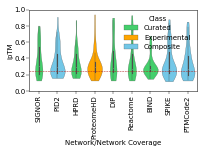

In [27]:
_ = plt.figure(figsize=(3,1.5))
sns.violinplot(data=plot_data, x='Network/Network Coverage', y='ipTM', cut=0, linewidth=0.25, hue='Class', palette=['#44cf6c', '#ffa500', '#73c7e7'], 
                saturation=1, order=order)#, cut=0, inner='', fill=True)
plt.hlines(rn_df.ipTM.median(), -0.5, len(sig_nets) - 0.5, color='firebrick', linestyle='--', linewidth=0.5)
plt.ylim(0, 1)
plt.xlim(-0.5, len(sig_nets)-0.5)
ax  = plt.gca()
ax.tick_params(axis='x', rotation=90)
plt.savefig(figdir + 'Fig5F_Network_ipTM.jpg', bbox_inches='tight', dpi=300)

## Figure 5G - ipTM of potentially novel predicted interactions

In [64]:
# extract the subset of results representing previously unreported interactions
unreported_df = af_df.copy()[af_df['Analysis Set'] == 'Unreported']
unreported_df_top = unreported_df.sort_values('Model Confidence', ascending=False).drop_duplicates(subset=['Pair_str', 'Network/Network Coverage'], keep='first')

Check if the unreported ipTM scores also have a similar distribution shape

In [29]:
print("Unreported pairs skew:")
skewtest(unreported_df_top.ipTM)

Unreported pairs skew:


SkewtestResult(statistic=19.51920336904353, pvalue=7.540473876140386e-85)

In [30]:
# Identify threshold for AF-supported
iptm_th = rn_df.sort_values('Model Confidence', ascending=False).drop_duplicates(subset=['Pair_str'], keep='first').ipTM.describe(percentiles=[0.95])['95%']
print('ipTM threshold:', iptm_th)  

ipTM threshold: 0.53


In [31]:
unreported_df_top = unreported_df_top.assign(AFSupported = unreported_df_top.ipTM > iptm_th)

In [32]:
print(f'Unique AF Supported interactions: {unreported_df_top[unreported_df_top.AFSupported].Pair_str.nunique()}')

Unique AF Supported interactions: 126


In [33]:
print('Network validation rates:')
unreported_df_top.groupby('Network/Network Coverage').AFSupported.mean().sort_values(ascending=False).head(5)

Network validation rates:


Network/Network Coverage
SIGNOR      0.640000
Reactome    0.239130
MINT        0.140000
IntAct      0.102041
PID2        0.102041
Name: AFSupported, dtype: float64

In [34]:
# Plot the 10 networks with the highest mean ipTM scores
plot_nets = unreported_df_top.groupby('Network/Network Coverage').ipTM.mean().sort_values(ascending=False).index[0:10]

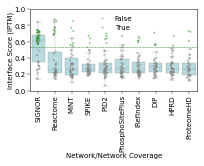

In [35]:
_ = plt.figure(figsize=(3,1.5))

sns.stripplot(data=unreported_df_top, x='Network/Network Coverage', y='ipTM', s=2, alpha=0.5, hue='AFSupported', palette=['forestgreen', 'grey'][::-1], order=plot_nets)
sns.boxplot(data=unreported_df_top[unreported_df_top['Network/Network Coverage'].isin(plot_nets)], x='Network/Network Coverage', y='ipTM', fliersize=0, linecolor='grey', color='powderblue', linewidth=0.25)
plt.hlines(iptm_th, -0.5, 9.5, color='forestgreen', linestyle='--', linewidth=0.5)
plt.ylim(0,1)
plt.ylabel('Interface Score (IPTM)')
plt.xlim(-0.5, 9.5)
plt.gca().tick_params(axis='x', rotation=90)
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore deprecation warning
    plt.savefig(figdir + 'Fig5G_iptm_af_support.jpg', bbox_inches='tight', dpi=300)

Statistics

In [36]:
# mann whitney u test for each network against the random pairs
muAF_results = {}
for net in unreported_df_top['Network/Network Coverage'].unique():
    muAF_rn = mannwhitneyu(unreported_df_top[unreported_df_top['Network/Network Coverage'] == net].ipTM, rn_df.ipTM).pvalue
    muAF_results[net] = {'p': muAF_rn, 'median': unreported_df_top[unreported_df_top['Network/Network Coverage'] == net].ipTM.median()}
muAF_df = pd.DataFrame.from_dict(muAF_results, orient='index')
muAF_df['q'] = fdrcorrection(muAF_df['p'])[1]
muAF_df['higher_ipTM'] = muAF_df['median'] > rn_df.ipTM.median()

In [37]:
muAF_df[muAF_df.higher_ipTM].sort_values('q')

,p,median,q,higher_ipTM
SIGNOR,1.227117e-17,0.610,4.540332e-16,True
PathwayCommons,1.055264e-02,0.280,3.003444e-02,True
SPIKE,2.131293e-02,0.260,5.632703e-02,True
Reactome,2.450379e-02,0.255,5.666502e-02,True
DIP,4.140477e-02,0.290,9.011625e-02,True
HPRD,6.532143e-02,0.265,1.342718e-01,True
MINT,8.293506e-02,0.260,1.514475e-01,True
PID2,8.595671e-02,0.270,1.514475e-01,True
iRefIndex,8.527178e-02,0.245,1.514475e-01,True
PhosphoSitePlus,1.152758e-01,0.260,1.854437e-01,True


## Supplemental Figures

### Load PDB data

For processing of raw PDB data, see `StateOFTheInteractomes_Notebooks/Supplemental_Code/PDB_processing.py`. For large datasets, PDB provides a batch download. Note that the data for complexes and single proteins were downloaded separately as outlined in the Methods:

> Lists of experimentally resolved structures in the Protein Data Bank (PDB) were downloaded on August 14, 2024. Interactions with experimentally resolved structures were broadly defined as any protein pair reported as part of a human complex with at least two distinct protein entities that could be mapped to NCBI Gene IDs via UniProt Accession Codes. Proteins with individual experimentally resolved structures were broadly defined as any protein identified from structures containing one distinct protein entity (including homodimers and partial structures) that could be mapped to NCBI Gene IDs via UniProt Accession Codes. 

**Usage:**
```
python PDB_processing.py <datadir> <download_id> <complex|protein>
# e.g. for complex data:
python PDB_processing.py /path/to/pdb c45a276a8adf932dc105b8942846e27b complex
```


In [38]:
pdb_edges = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigS4_pdb_edge_list.txt'), sep='\t', index_col=0)
with open(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigS4_pdb_node_list.txt'), 'r') as f:
    pdb_nodes = [int(x.strip()) for x in f.readlines()]

In [39]:
pdb_edges['Pair_str'] = pdb_edges['GeneA'].astype(str) + '-' + pdb_edges['GeneB'].astype(str)
pdb_edges['EdgeInPDB'] = 1

In [40]:
def add_pdb_info(top_mods_df, pdb_edge_list, singles, group_by, return_original_df=False):
    top_mods_df = top_mods_df.merge(pdb_edge_list.loc[:,('Pair_str', 'EdgeInPDB')], on='Pair_str', how='left')
    top_mods_df['NodesInPDB'] = top_mods_df.apply(lambda x: np.sum([int(x['NCBI Gene ID A']) in singles, int(x['NCBI Gene ID B']) in singles]) , axis=1)
    if return_original_df:
        return top_mods_df
    edge_df = top_mods_df.groupby(group_by).agg({
        'EdgeInPDB': 'value_counts'
    }).unstack().fillna(0)
    edge_df.columns = ['_'.join(map(str, col)).strip() for col in edge_df.columns.values]
    edge_df = edge_df.reset_index()
    aggregated_df = top_mods_df[top_mods_df['EdgeInPDB'].isna()].groupby(group_by).agg({
        'NodesInPDB': 'value_counts'
    }).unstack().fillna(0)
    aggregated_df.columns = ['_'.join(map(str, col)).strip() for col in aggregated_df.columns.values]

    # Reset the index for plotting
    aggregated_df = aggregated_df.reset_index()
    plot_pdb_df = aggregated_df.merge(edge_df, on=group_by, how='outer').set_index(group_by).fillna(0)
    bin_counts = top_mods_df[group_by].value_counts().sort_index()
    plot_pdb_df_frac = np.divide(plot_pdb_df.T,  bin_counts.values).T
    col_names = {'NodesInPDB_0': 'None', 'NodesInPDB_1': 'One Individual Protein', 'NodesInPDB_2': 'Both Individual Proteins', 'EdgeInPDB_1.0': 'Interaction'}
    return plot_pdb_df.rename(columns=col_names), plot_pdb_df_frac.rename(columns=col_names)

### Appendix Figure S4A - PDB vs Network Coverage

In [41]:
coverage_pdb, coverage_pdb_frac = add_pdb_info(coverage_df_top, pdb_edges, pdb_nodes, group_by='Edge_Bin')

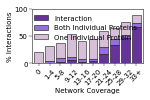

In [42]:
_ = plt.figure(figsize=(2, 1))
ax = plt.gca()
plot_pdb_df_frac = coverage_pdb_frac.loc[:, ('Interaction', 'Both Individual Proteins', 'One Individual Protein')]
plot_pdb_df_frac.plot(kind='bar', stacked=True, color=['rebeccapurple', 'mediumpurple', 'thistle'], ax=ax, 
                      width=0.8, edgecolor='black', linewidth=0.5)

_ = plt.xticks([i for i in range(10)], labels=[0, '1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28', '29-32', '33+'], 
               rotation=45)
plt.ylabel('% Interactions')
plt.xlabel('Network Coverage')
_ = plt.yticks([0,0.5,1], ['0', '50', '100'])

plt.savefig(os.path.join(figdir, 'FigS4A_PDB_coverage_bar_plot.jpg'), bbox_inches='tight')


### Appendix Figure S4B - PDB representation of network sampled interactions

In [43]:
network_pdb, network_pdb_frac = add_pdb_info(network_df_top, pdb_edges, pdb_nodes,group_by='Network/Network Coverage' )

In [44]:
net_order = network_df_top.groupby('Network/Network Coverage').ipTM.median().sort_values(ascending=False).index.to_list()

In [45]:
# consider networks with significantly different median ipTM in either direction
sig_nets = [x for x in list(mu_df[mu_df.fdr_rn < 0.15].index)]

In [46]:
network_df_top['Class'] = network_df_top['Network/Network Coverage'].apply(lambda x: network_classes[x] if x in sig_nets else 'x')

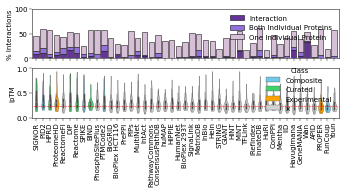

In [47]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(5.5, 2), sharex=True)
sns.violinplot(network_df_top, x='Network/Network Coverage', y='ipTM', hue='Class',
               palette = [blue, green, orange, 'lightgrey'], hue_order=['Composite', 'Curated', 'Experimental', 'x'], 
               order=net_order, ax=ax2, saturation=1, cut=0)
ax2.hlines(random_median, -0.5, 44.5,color='red', linestyle='--', linewidth=0.5)
ax2.tick_params(axis='x', rotation=90)
ax2.set_xlim(-0.5, 44.5)


net_pdb_df_frac = network_pdb_frac.loc[:,  ('Interaction', 'Both Individual Proteins', 'One Individual Protein')]
net_pdb_df_frac.loc[net_order].plot(kind='bar', stacked=True, color=['rebeccapurple', 'mediumpurple', 'thistle'], ax=ax1, 
                                    width=0.8, edgecolor='black', linewidth=0.5)
ax1.set_ylabel('% Interactions')
_ = ax1.set_yticks([0,0.5,1], ['0', '50', '100'])
ax2.set_ylim(0,1)
plt.savefig(os.path.join(figdir, 'FigS4B_pdb_network_specific_full_results.jpg'),dpi=400, bbox_inches='tight')
_ = ax2.set_xlabel('')

### Appendix Figure S4C - Correlation between PDB presence and ipTM score

In [48]:
plot_scatter = network_pdb_frac.join(network_df_top.groupby('Network/Network Coverage').ipTM.mean())

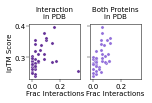

In [49]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(2,1), sharex=True, sharey=True)
sns.scatterplot(plot_scatter, x='Both Individual Proteins', y='ipTM', color='mediumpurple', ax=ax2, s=10)
sns.scatterplot(plot_scatter, x='Interaction', y='ipTM', color='rebeccapurple', ax=ax1, s=10)
ax1.set_ylabel('ipTM Score')
ax1.set_xlabel('Frac Interactions')
_ = ax1.set_title('Interaction\nin PDB', fontsize=7)
_ = ax2.set_title('Both Proteins\nin PDB', fontsize=7)
ax2.set_xlabel('Frac Interactions')
plt.savefig(os.path.join(figdir, 'FigS4C_pdb_network_scatter.jpg'), dpi=400, bbox_inches='tight')

In [50]:
plot_scatter.corr().ipTM

None                       -0.288973
One Individual Protein     -0.008331
Both Individual Proteins    0.526767
Interaction                 0.286343
ipTM                        1.000000
Name: ipTM, dtype: float64

### Appendix Figure S4D - AF Support for previously unreported interactions across all networks

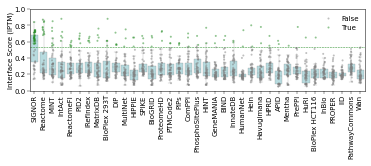

In [51]:
_ = plt.figure(figsize=(6,1.5))
plot_all_nets = unreported_df_top.groupby('Network/Network Coverage').AFSupported.sum().sort_values(ascending=False).index

sns.stripplot(data=unreported_df_top, x='Network/Network Coverage', y='ipTM', s=2, alpha=0.5, hue='AFSupported', palette=['forestgreen', 'grey'][::-1], order=plot_all_nets)
sns.boxplot(data=unreported_df_top[unreported_df_top['Network/Network Coverage'].isin(plot_all_nets)], x='Network/Network Coverage', y='ipTM', fliersize=0, linecolor='grey', color='powderblue', linewidth=0.25)
plt.hlines(iptm_th, -0.5, len(plot_all_nets)-0.5, color='forestgreen', linestyle='--', linewidth=0.5)
plt.ylim(0,1)
plt.ylabel('Interface Score (IPTM)')
plt.xlim(-0.5, len(plot_all_nets)-0.5)
_ = plt.xlabel('')
plt.gca().tick_params(axis='x', rotation=90)
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore deprecation warning
    plt.savefig(figdir + 'FigS4D_iptm_af_support.jpg', bbox_inches='tight', dpi=300)


### Appendix Figure S4E - PDB presence of AF-supported, previously unreported interactions

In [52]:
supported_pdb_df, supported_pdb_df_frac = add_pdb_info(unreported_df_top[unreported_df_top.AFSupported].drop_duplicates(subset=['Pair_str']), 
                                                   pdb_edges, pdb_nodes, 'Network/Network Coverage')

In [53]:
unsupported_pdb_df, unsupported_pdb_df_frac = add_pdb_info(unreported_df_top[~unreported_df_top.AFSupported].drop_duplicates(subset=['Pair_str']), 
                                                 pdb_edges, pdb_nodes, 'Network/Network Coverage')

In [54]:
# add null data for networks with no AF-supported interactions
missing_nets = [net for net in order if net not in supported_pdb_df_frac.index]
add_df = pd.DataFrame({x:0 for x in supported_pdb_df_frac.columns}, index=missing_nets)
supported_pdb_df_frac = pd.concat([supported_pdb_df_frac, add_df])

In [55]:
supported = supported_pdb_df.sum(axis=0)
unsupported = unsupported_pdb_df.sum(axis=0)
results_mat = pd.DataFrame({'Supported':supported, "Unsupported":unsupported})

Check that all expected values are > 5, for chi-squared test of independence

In [56]:
# 
expected = results_mat.mean(axis=1)*results_mat.mean(axis=1)
chi2, p, dof, expected = chi2_contingency(results_mat)
print(expected)

[[  93.11392405 1132.88607595]
 [  30.53164557  371.46835443]
 [   2.35443038   28.64556962]]


This assumption is not met so consolidate the PDB categories

In [57]:
results_mat_consolidated = results_mat.T.copy()
results_mat_consolidated['Any PDB'] = results_mat_consolidated['One Individual Protein'] + results_mat_consolidated['Both Individual Proteins']
results_mat_consolidated = results_mat_consolidated.drop(columns=['One Individual Protein', 'Both Individual Proteins'])

In [58]:
results_mat_consolidated

,None,Any PDB
Supported,103.0,23.0
Unsupported,1123.0,410.0


Perform chi-squared test

In [59]:


chi2, p, dof, expected = chi2_contingency(results_mat_consolidated)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

Chi-square statistic: 3.9229811352952146
P-value: 0.04763034741364811
Degrees of freedom: 1
Expected frequencies:
[[  93.11392405   32.88607595]
 [1132.88607595  400.11392405]]


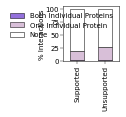

In [60]:
_ = plt.figure(figsize=(1,1))
ax = plt.gca()
# 'rebeccapurple', 'mediumpurple', 'thistle', 'white'
prop_df = np.divide(results_mat, results_mat.sum(axis=0))
prop_df.T.loc[:, ('Both Individual Proteins', 'One Individual Protein', 'None')].plot(kind='bar', stacked=True, color=['mediumpurple', 'thistle', 'white'], edgecolor='black', linewidth=0.5, ax=ax)
plt.ylabel('% Interactions')
_ = plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 25, 50, 75, 100])
plt.savefig(os.path.join(figdir, 'FigS4E_iptm_supported_pdb_bars.jpg'), bbox_inches='tight')

### Fig. EV5 - AF Supported Interactions

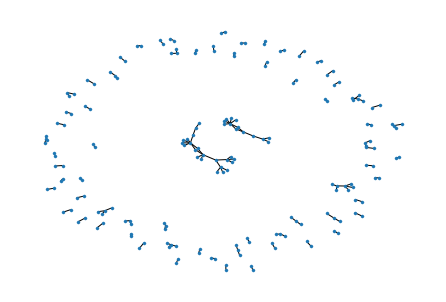

In [61]:
G_supported = nx.from_pandas_edgelist(unreported_df_top[unreported_df_top.AFSupported], source='NCBI Gene ID A', 
                                      target='NCBI Gene ID B', 
                                      edge_attr=['Network/Network Coverage', 'pTM', 'ipTM', 'Model Confidence'])
nx.draw_spring(G_supported, node_size=10)